# This notebook takes data prepared in Prep-data.ipynb, trains a Keras model for image classification, and then applies the model on test data. It also saves model for deployment to Sagemaker

In [61]:
!rm -rf keras_results/

In [22]:
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, MaxPool2D
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import Dense, Dropout, Activation

import boto3, re
from sagemaker import get_execution_role

role = get_execution_role()

import keras
from keras.models import model_from_json


from tensorflow.python.saved_model import builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants

import json
import sagemaker

sagemaker_session = sagemaker.Session()

from keras import backend as K

from sagemaker.tensorflow.model import TensorFlowModel



def get_file_path_list(path):  
    full_path_list = []
    for path, subdirs, files in os.walk(path):
        for filename in files:
            f = os.path.join(path, filename)
            full_path_list.append(f)
    return full_path_list

In [250]:
# latest data before SPD
# x_train = np.load('x_train_comb_clean_120k_shift1.npy') # load
# y_train = np.load('y_train_comb_clean_120k_shift1.npy') # load

# x_test = np.load('x_test_comb_clean_120k_shift1.npy') # load
# y_test = np.load('y_test_comb_clean_120k_shift1.npy') # load


# x_train = np.load('x_train_new_spd_200k.npy') # load
# y_train = np.load('y_train_new_spd_200k.npy') # load

# x_test = np.load('x_test_new_spd_200k.npy') # load
# y_test = np.load('y_test_new_spd_200k.npy') # load

x_train = np.load('x_train_new_spd_300k.npy') # load
y_train = np.load('y_train_new_spd_300k.npy') # load

x_test = np.load('x_test_new_spd_300k.npy') # load
y_test = np.load('y_test_new_spd_300k.npy') # load

In [251]:
# let's print the shape before we reshape and normalize
print("X_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", x_test.shape)
print("y_test shape", y_test.shape)

# building the input vector from the 28x28 pixels
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# print the final input shape ready for training
print("Train matrix shape", x_train.shape)
print("Test matrix shape", x_test.shape)


X_train shape (309770, 28, 28, 1)
y_train shape (309770,)
X_test shape (89905, 28, 28, 1)
y_test shape (89905,)
Train matrix shape (309770, 784)
Test matrix shape (89905, 784)


In [252]:
###. NEW  ###. 

# building a linear stack of layers with the sequential model
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))                            
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

# model.add(Dense(10))
model.add(Dense(11))
model.add(Activation('softmax'))

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          epochs=40,
          verbose=2,
          validation_data=(x_test, y_test))

Train on 309770 samples, validate on 89905 samples
Epoch 1/40
 - 49s - loss: 1.4255 - accuracy: 0.5206 - val_loss: 1.0334 - val_accuracy: 0.6597
Epoch 2/40
 - 48s - loss: 0.9425 - accuracy: 0.6902 - val_loss: 0.7771 - val_accuracy: 0.7468
Epoch 3/40
 - 48s - loss: 0.7767 - accuracy: 0.7445 - val_loss: 0.6525 - val_accuracy: 0.7853
Epoch 4/40
 - 48s - loss: 0.6787 - accuracy: 0.7766 - val_loss: 0.5738 - val_accuracy: 0.8150
Epoch 5/40
 - 48s - loss: 0.6105 - accuracy: 0.8003 - val_loss: 0.5290 - val_accuracy: 0.8306
Epoch 6/40
 - 48s - loss: 0.5638 - accuracy: 0.8153 - val_loss: 0.4419 - val_accuracy: 0.8608
Epoch 7/40
 - 48s - loss: 0.5272 - accuracy: 0.8275 - val_loss: 0.4161 - val_accuracy: 0.8710
Epoch 8/40
 - 48s - loss: 0.4974 - accuracy: 0.8374 - val_loss: 0.3977 - val_accuracy: 0.8761
Epoch 9/40
 - 48s - loss: 0.4791 - accuracy: 0.8429 - val_loss: 0.4066 - val_accuracy: 0.8725
Epoch 10/40
 - 48s - loss: 0.4610 - accuracy: 0.8486 - val_loss: 0.3533 - val_accuracy: 0.8921
Epoch 11

In [ ]:
history = model.fit(x_train, y_train,
          epochs=20,
          verbose=2,
          validation_data=(x_test, y_test))

Train on 309770 samples, validate on 89905 samples
Epoch 1/20
 - 48s - loss: 0.2595 - accuracy: 0.9147 - val_loss: 0.2139 - val_accuracy: 0.9380
Epoch 2/20
 - 48s - loss: 0.2598 - accuracy: 0.9149 - val_loss: 0.2216 - val_accuracy: 0.9364
Epoch 3/20
 - 48s - loss: 0.2590 - accuracy: 0.9151 - val_loss: 0.2063 - val_accuracy: 0.9417
Epoch 4/20
 - 48s - loss: 0.2561 - accuracy: 0.9157 - val_loss: 0.2135 - val_accuracy: 0.9403
Epoch 5/20
 - 48s - loss: 0.2575 - accuracy: 0.9160 - val_loss: 0.2115 - val_accuracy: 0.9385
Epoch 6/20
 - 48s - loss: 0.2552 - accuracy: 0.9166 - val_loss: 0.2092 - val_accuracy: 0.9428
Epoch 7/20
 - 48s - loss: 0.2557 - accuracy: 0.9162 - val_loss: 0.2144 - val_accuracy: 0.9385
Epoch 8/20
 - 48s - loss: 0.2528 - accuracy: 0.9172 - val_loss: 0.2088 - val_accuracy: 0.9406
Epoch 9/20
 - 48s - loss: 0.2539 - accuracy: 0.9166 - val_loss: 0.2228 - val_accuracy: 0.9345
Epoch 10/20
 - 48s - loss: 0.2498 - accuracy: 0.9179 - val_loss: 0.2032 - val_accuracy: 0.9435
Epoch 11

In [272]:
59/63

0.9365079365079365

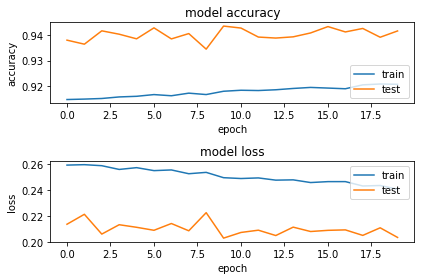

In [273]:
# saving the model
# save_dir = "keras_results/"
# model_name = 'keras_mnist.h5'
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('Saved trained model at %s ' % model_path)

# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

In [95]:
model.evaluate(x_test, y_test)

53152/53152 [==============================] - 2s 29us/step


[0.248957134534948, 0.9472079873085022]

# New data test

In [125]:
############################
image_files = get_file_path_list('test_combined')

image_files = get_file_path_list('../Extract-Cells/saved-images/')

correct = 0
for f in image_files:
    im_gray = cv2.imread(f)
    im_gray = cv2.cvtColor(im_gray, cv2.COLOR_BGR2GRAY)
#     im_gray = border(im_gray, 5) #########

    im_gray = im_gray/255
    dim = (28, 28)
    im_gray = cv2.resize(im_gray, dim, interpolation = cv2.INTER_AREA)
    im_gray = im_gray.astype('float32')

    im_gray =im_gray.reshape(1, 28, 28)
    pred = model.predict(im_gray.reshape(1, 784))
#     pred = model.predict(im_gray.reshape(1, 28, 28, 1))

    if pred.argmax()!= int(f.split('/')[-1].split('-')[0]):
#         correct+=1
        plt.figure()
        plt.imshow(im_gray.reshape(28, 28),cmap='Greys')
        print(pred.argmax())
        print(f)
    if pred.argmax()== int(f.split('/')[-1].split('-')[0]):
        correct+=1
    
    plt.show()

ValueError: invalid literal for int() with base 10: '30.png'

In [152]:
im_gray = cv2.imread(f)
im_gray = cv2.cvtColor(im_gray, cv2.COLOR_BGR2GRAY)

In [153]:
im_gray

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

10
test_march29/10-14.jpg


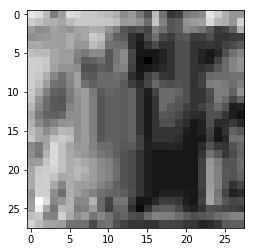

7
test_march29/7-10.jpg


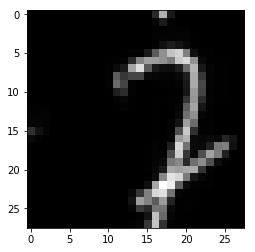

8
test_march29/8-1000.jpg


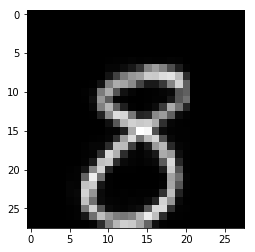

4
test_march29/7-9.jpg


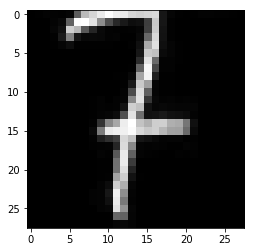

10
test_march29/10-19.jpg


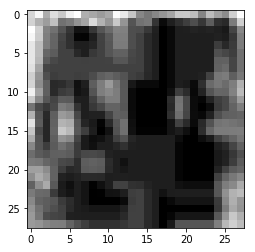

7
test_march29/7-12.jpg


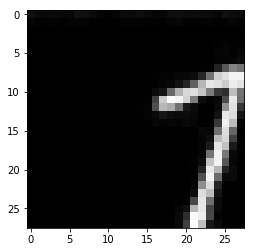

10
test_march29/10-20.jpg


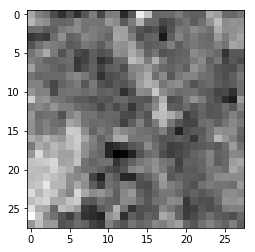

8
test_march29/8-996.jpg


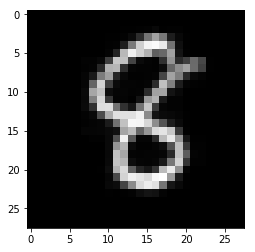

7
test_march29/7-8.jpg


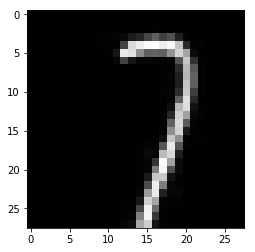

8
test_march29/8-997.jpg


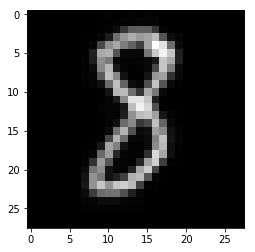

0
test_march29/0-2.jpg


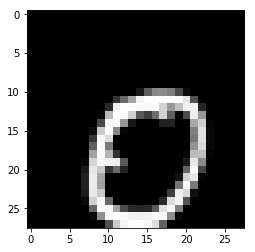

7
test_march29/7-11.jpg


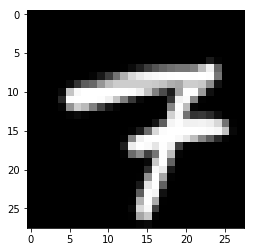

10
test_march29/10-18.jpg


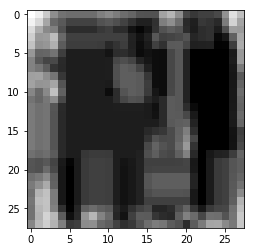

0
test_march29/0-3.jpg


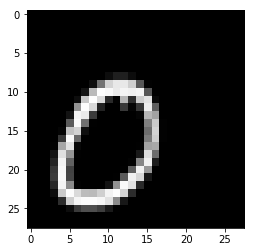

8
test_march29/8-999.jpg


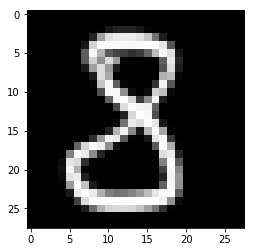

0
test_march29/0-5.jpg


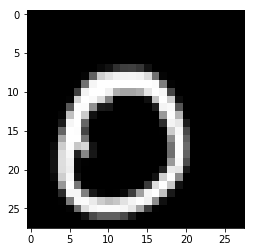

10
test_march29/10-15.jpg


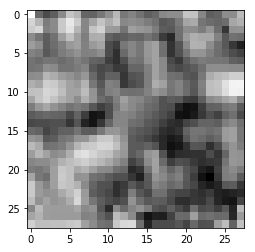

10
test_march29/10-17.jpg


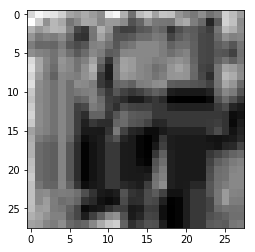

0
test_march29/0-4.jpg


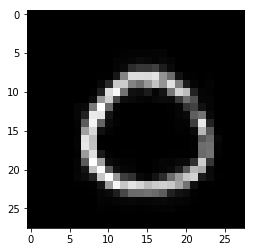

10
test_march29/10-16.jpg


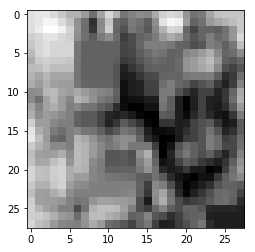

8
test_march29/8-998.jpg


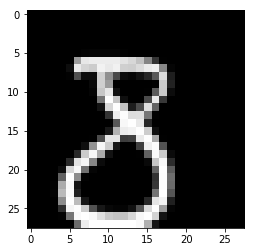

In [167]:
############################
image_files = get_file_path_list('test_combined')

image_files = get_file_path_list('../Extract-Cells/saved-images/')
image_files = get_file_path_list('test_march29')

correct = 0
for f in image_files:
    im_gray = cv2.imread(f)
    im_gray = cv2.cvtColor(im_gray, cv2.COLOR_BGR2GRAY)
#     im_gray = border(im_gray, 5) #########

#     im_gray = im_gray/(255)
    im_gray = im_gray/(255*255)
    dim = (28, 28)
    im_gray = cv2.resize(im_gray, dim, interpolation = cv2.INTER_AREA)
    im_gray = im_gray.astype('float32')

#     im_gray =im_gray.reshape(1, 28, 28)
    
    pred = model.predict(im_gray.reshape(1, 784))
#     pred = model.predict(im_gray.reshape(1, 28, 28, 1))


    plt.figure()
    plt.imshow(im_gray.reshape(28, 28),cmap='Greys')
    print(pred.argmax())
    print(f)

    
    plt.show()

5
test_march29/8-998.jpg


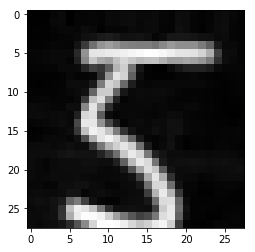

In [168]:
img = x_test[12110]
pred = model.predict(img.reshape(1, 784))
#     pred = model.predict(im_gray.reshape(1, 28, 28, 1))


plt.figure()
plt.imshow(img.reshape(28, 28),cmap='Greys')
print(pred.argmax())
print(f)

In [127]:
pred

array([[0.06953391, 0.1864274 , 0.04871943, 0.08537118, 0.09413139,
        0.08901718, 0.05766905, 0.08601049, 0.04968429, 0.12138509,
        0.11205051]], dtype=float32)

In [121]:
len(image_files)

160

In [72]:
# No border, 100 epocks 300k
correct/len(image_files)

0.9477124183006536

In [97]:
# No border, 80 epocks 300k
correct/len(image_files)

0.9215686274509803

# 80 epochs 120k, no border

In [43]:
correct/len(image_files)

0.8921568627450981

In [47]:
correct/len(image_files)

0.8529411764705882

In [ ]:
train with 80 not 120

In [88]:
30/33

0.9090909090909091

# Save mode to be used by keras-tensorflow-model-deployment for Deployment

In [231]:
!rm -rf ../keras_model

In [232]:
!mkdir ../keras_model

In [233]:
!ls ../keras_model

In [234]:
json_string = model.to_json()

In [235]:
with open('../keras_model/model.json', 'w') as fp:
    # json.dump(result, fp, indent=4)
    print(json_string, file=fp)

In [236]:
!pwd

/home/ec2-user/SageMaker/mxnet-mnist-byom


In [237]:
json_file = open('/home/ec2-user/SageMaker/keras_model/'+'model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [238]:
save_dir = "../keras_model/"
model_name = 'model-weights.h5'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

In [239]:
!ls ../keras_model

model.json  model-weights.h5


In [270]:

crop_factor = .1

import json
import boto3
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from pylab import rcParams

client = boto3.client('runtime.sagemaker')


%matplotlib inline
try:
    from PIL import Image
except ImportError:
    import Image
# import pytesseract

#read your file
file=r'3.png'
file=r'img_from_pdf/3-100.png'
file='img_from_pdf/2-103.png'
file=r'kevin_test.png'
file = '../5-0.png'
# file=r'image_form.png'

img = cv2.imread(file,0)
img.shape

#thresholding the image to a binary image
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

#inverting the image 
img_bin = 255-img_bin


############################################################################################################
#countcol(width) of kernel as 100th of total width
# # kernel_len = np.array(img).shape[1]//100
# kernel_len = np.array(img).shape[1]//100

# # Defining a vertical kernel to detect all vertical lines of image 
# ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
# # Defining a horizontal kernel to detect all horizontal lines of image
# hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
# # A kernel of 2x2
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))


# kernel_len = np.array(img).shape[1]//100
kernel_len = np.array(img).shape[1]//800

# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

############################################################################################################
#Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)


#Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)


# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
#Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite("img_vh.jpg", img_vh)
bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)


#Plotting the generated image
# plotting = plt.imshow(bitnot,cmap='gray')
# plt.show()

# Detect contours for following box detection
# contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

_, contours, _= cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

#Get mean of heights
mean = np.mean(heights)

#Create list box to store all boxes in  
box = []
# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
#     if (w<1000 and h<500):
#     print(w)
########################################################################
#####################   updated needed     #############################
########################################################################
#     if (w<75 and h<55 and w/h< 2 and w/h> 1):
    if (w < 400 and w > 100 and w/h< 2 and w/h> 1):
#         print(w)
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
########################################################################
########################################################################
########################################################################        
# plotting = plt.imshow(image,cmap='gray')
# plt.show()

#Creating two lists to define row and column in which cell is located
row=[]
column=[]
j=0
#Sorting the boxes to their respective row and column
for i in range(len(box)):    
        
    if(i==0):
        column.append(box[i])
        previous=box[i]    
    
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]            
            
            if(i==len(box)-1):
                row.append(column)        
            
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
            
# print(column)
# print(row)

#calculating maximum number of cells
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

#Retrieving the center of each column

center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]

center=np.array(center)
center.sort()
# print(center)
#Regarding the distance to the columns center, the boxes are arranged in respective order

finalboxes = []
for i in range(len(row)): #000000000000    range(len(row))   00000000000000000000000000000000000000000000000000000000000000000000000000
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)


#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
pic = 0
meanvals = []
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dim = (64, 64)
                resizing = cv2.resize(resizing, dim, interpolation = cv2.INTER_AREA)
                s0 = resizing.shape[0]
                s1 = resizing.shape[1]
                im_gray = resizing[int(s0*crop_factor):int(s0*(1-crop_factor)), int(s1*crop_factor):int(s1*(1-crop_factor))]

                im_gray = im_gray/(255*255)
                dim = (28, 28)
                im_gray = cv2.resize(im_gray, dim, interpolation = cv2.INTER_AREA)

                im_gray = im_gray.astype('float32')
     
                #################
                pred = model.predict(im_gray.reshape(1, 784))          
                ###################

                out = pred.argmax()
                if out ==10:
                    out = ''
                inner = inner +" "+ str(out)
            outer.append(inner)
        
#Creating a dataframe of the generated OCR list
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row), countcol))
print(dataframe)
data = dataframe.style.set_properties(align="left")
#Converting it in a excel-file
data.to_excel(file.split('/')[-1].split('.')[0]+'.xlsx')

    0   1   2   3   4   5   6  7  8  9   ...  14  15 16 17 18 19 20  21 22 23
0                                        ...                                 
1    1   3                               ...   2   4                  1      
2    4   4   4   7   6   1   7           ...                                 
3    3   7   1   9   4   6   7           ...                                 
4    1   0   0                           ...                                 
5    3   3                               ...                                 
6    3   3                               ...                                 
7                                        ...                                 
8                                        ...                                 
9                                        ...                                 
10                                       ...                                 
11                                       ...                    

In [181]:
img

In [185]:
file = '../0-0.png'

In [256]:
file.split('/')[-1].split('.')[0]+'.xlsx'

'4-0.xlsx'